# Exp.06. 영화리뷰 텍스트 감상 분석하기<br>

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. 3가지 이상의 모델이 성공적으로 시도됨<br>
   <b>시도 하였음.</b><br><br>
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. 
   gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함<br>
   <b>gensim을 활용하여 임베딩레이어분석</b><br><br>
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함<br>
   <b>달성함 : accuracy: 0.8526</b><br>
   <b>프로젝트 내용인 [3. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기]는 파일의 제일 마지막에 있습니다.<br>프로젝트 앞부분에 프로젝트 회고가있습니다</b><br>
   <br> 


## 1. 시작 LMS 학습내용입니다.

In [84]:
#  단어의 의미를 나타내는 벡터를 짝지어 보자!!!


# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 for문과 split()메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = []
for ii in sentences:
    for j in ii.split():
        word_list.append(j)

# 중복 재거        
word_list = list(set(word_list))
print(word_list)


# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
# <PAD> : 패딩용 단어
# <BOS> : 문장의 시작지점
# <UNK> : 사전에 없는(Unknown) 단어

index_to_word={0:'<PAD>', 1:'<BOS>', 2:'<UNK>'}  # 빈 딕셔너리를 만들어서

for i in range(3, 3+len(word_list)):
    index_to_word[i] = word_list.pop()

print(index_to_word)

# dictionary 안의 index:value를 value:index로 변경 하는 방법
# 위에서는 미리 dictionary를 만뜰때 부터 value:index순으로 만들었습니다. 
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

['happy', 'lunch', 'eat', 'feel', 'hungry', 'now', 'i']
{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'now', 5: 'hungry', 6: 'feel', 7: 'eat', 8: 'lunch', 9: 'happy'}
{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'now': 4, 'hungry': 5, 'feel': 6, 'eat': 7, 'lunch': 8, 'happy': 9}
6


In [85]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]


# def get_encoded_sentence(sentence, word_to_index):
#     llist = sentence.split()
#     return llist
    

print(get_encoded_sentence('i eat lunch', word_to_index))


[1, 3, 7, 8]


In [86]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 6, 5], [1, 3, 7, 8], [1, 4, 3, 6, 9]]


In [87]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i now hungry


In [88]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']



## 1.1. Embedding 레이어의 등장 및 사용


In [89]:
import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
# Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 합니다
# '<PAD>'를 넣어서 길이를 일정하게 해주는 함수 pad_sequences() 
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

output = embedding(raw_inputs)
print(output)

# output의 shape인 (3, 5, 4)의 의미는
# => 3 : 3개의 문장이 입력으로 들어왔음.
#    5 : 한 문장의 길이는 5로 통일 되어있다. (maxlen=5)
#    4 : word vector의 차원이 4차원이다. (위에서 정의해주었다. word_vector_dim=4)

[[1 3 6 5 0]
 [1 3 7 8 0]
 [1 4 3 6 9]]
tf.Tensor(
[[[ 0.00752689  0.03957883 -0.04318301  0.02913559]
  [-0.01931833  0.02061502 -0.03200634 -0.04406733]
  [-0.03807358  0.02765019 -0.00351473  0.03275564]
  [ 0.04369492 -0.00398966  0.00618585  0.02217956]
  [-0.04510443  0.02666372  0.04828746  0.04290268]]

 [[ 0.00752689  0.03957883 -0.04318301  0.02913559]
  [-0.01931833  0.02061502 -0.03200634 -0.04406733]
  [-0.01496235  0.03947923 -0.04767454  0.04482258]
  [-0.01800687  0.04751373  0.0301993  -0.0457366 ]
  [-0.04510443  0.02666372  0.04828746  0.04290268]]

 [[ 0.00752689  0.03957883 -0.04318301  0.02913559]
  [ 0.00369275  0.00562381 -0.02814255 -0.0358061 ]
  [-0.01931833  0.02061502 -0.03200634 -0.04406733]
  [-0.03807358  0.02765019 -0.00351473  0.03275564]
  [ 0.03810643 -0.03349192 -0.04213253 -0.04190534]]], shape=(3, 5, 4), dtype=float32)



## 1.2. RNN 구성 (널리 쓰이는 RNN인 LSTM 레이어를 사용)
LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)

In [90]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))                        # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model.add(tf.keras.layers.Dense(8, activation='relu'))    # 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 416       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________



## 1.3. CNN 구성 (1차원) CNN으로도 시퀀스 데이터를 처리할 수 있다
Conv1D(), GlobalMaxPooling1D() 2개를 사용하였음<br>
CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점

In [91]:
vocab_size = 10       # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 4)           40        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)               


## 1.4. CNN 구성 (1차원 짜리) CNN으로도 시퀀스 데이터를 처리할 수 있다
GlobalMaxPooling1D() 하나만 사용할 수도 있다.(성능 so so)<br>
CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점

In [92]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 4)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________



##  2.1. IMDB 영화리뷰 감성분석 (1) IMDB 데이터셋 분석 ( 긍정은 1, 부정은 0 )


In [93]:
# IMDb 데이터셋 다운로드 
# imdb.load_data() 호출 시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 
# 그 개수만큼의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성됨

imdb = tf.keras.datasets.imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 25000, 테스트 개수: 25000


In [94]:
# 데이터 확인 작업

print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨 (긍정은 1, 부정은 0)
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [95]:
# IMDb 데이터셋에서 제공한 딕셔너리 화인 

word_to_index = imdb.get_word_index() # 딕셔너리 가져오기
index_to_word = {index:word for word, index in word_to_index.items()} # 사용법 확인 하자??????
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [96]:
# IMDb 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word는 아래와 같이 보정되어야 합니다.
# 실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
#   시작은 1로 시작되고, 3칸을 뒤로 밀고 0,1,2,3 이렇게 4가지에 대한 값을 넣어준다.
#   <UNUSED>는 왜 넣었는지 모르겠다.??????? 

word_to_index = {k:(v+3) for k,v in word_to_index.items()} # 모든 인데긋를 사용법 확인 하자 ??????

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the']) # '4' 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [97]:
# encode된 텍스트가 정상적으로 decode 되는지 확인

print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨


this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [98]:
# 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미침
# 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보아야 한다. 

# 텍스트데이터 문장길이의 리스트를 생성한 후
total_data_text = list(x_train) + list(x_test)

# 문장 각각의 길이를 값으로 가지고 있는 길이(len())5,000의 리스트
num_tokens = [len(tokens) for tokens in total_data_text] 
num_tokens = np.array(num_tokens) # 리스트를 1차원 어레이로 변경 한다. 왜,???? 통계 개산하려고....

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [99]:
# padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽으로 하느냐에 따라 
# RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다
#    => 두 가지 방식을 한 번씩 다 적용해서 RNN을 학습시켜, 그 결과를 비교 !!!!!!!!

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(25000, 580)
(25000, 580)



##  2.2. IMDB 영화리뷰 감성분석 (2) 딥러닝 모델 설계와 훈련


In [100]:
# RNN모델 설계 하자!!!!!!!

import tensorflow as tf

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
# [[YOUR CODE]]
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))                        # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
model.add(tf.keras.layers.Dense(16, activation='relu'))    # 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_18 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 160,961
Trainable params: 160,961
Non-trainable params: 0
_________________________________________________________________


In [101]:
# 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용
# 적절한 validation 데이터는 몇 개가 좋을지 고민해 봅시다.
    
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건에서 10000건 분리
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [102]:
# train, validation, test 데이터의 개수를 변경 한다. (대략 70 : 15 : 15 정도로 분배한다)

# x_val = x_train[:4500]   
# y_val = y_train[:4500]

# partial_x_train = x_train[4500:]  
# partial_y_train = y_train[4500:]

# x_test = x_test[:4500]
# y_test = y_test[:4500]

# print("훈련 샘플 개수: {}, 검증(validation) 개수: {}, 테스트 개수: {}".format(len(partial_x_train), len(x_val), len(x_test1)))


In [103]:
# model 학습을 시작!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=18  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/18
30/30 [==============================] - 3s 45ms/step - loss: 0.6912 - accuracy: 0.5587 - val_loss: 0.6862 - val_accuracy: 0.6344
Epoch 2/18
30/30 [==============================] - 1s 31ms/step - loss: 0.6709 - accuracy: 0.7084 - val_loss: 0.6522 - val_accuracy: 0.7085
Epoch 3/18
30/30 [==============================] - 1s 30ms/step - loss: 0.5686 - accuracy: 0.7866 - val_loss: 0.4497 - val_accuracy: 0.8099
Epoch 4/18
30/30 [==============================] - 1s 29ms/step - loss: 0.3906 - accuracy: 0.8447 - val_loss: 0.3914 - val_accuracy: 0.8363
Epoch 5/18
30/30 [==============================] - 1s 30ms/step - loss: 0.2943 - accuracy: 0.8907 - val_loss: 0.3507 - val_accuracy: 0.8530
Epoch 6/18
30/30 [==============================] - 1s 30ms/step - loss: 0.2291 - accuracy: 0.9220 - val_loss: 0.3375 - val_accuracy: 0.8626
Epoch 7/18
30/30 [==============================] - 1s 30ms/step - loss: 0.1838 - accuracy: 0.9422 - val_loss: 0.3432 - val_accuracy: 0.8632
Epoch 8/18
30

In [104]:
# 학습이 끝난 모델을 테스트셋으로 평가하자 !!!!!!!!!

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)


782/782 - 5s - loss: 0.5873 - accuracy: 0.8383
[0.5873440504074097, 0.8383200168609619]



## 2.3. IMDB 영화리뷰 감성분석 (3) 평가


In [125]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있
# 이 데이터를 이용하여 그래프로 그려 보면서 전략을 짤수 있다. 

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


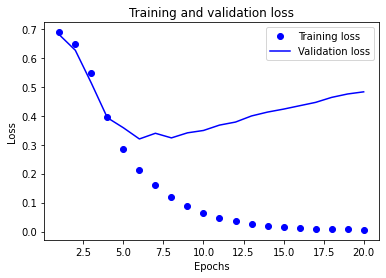

In [128]:
# 그래프 그리기

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

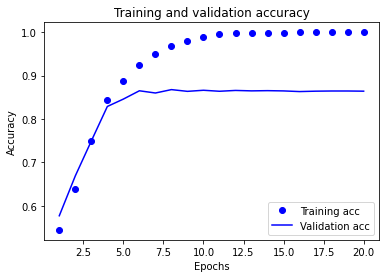

In [129]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## 2.4. IMDB 영화리뷰 감성분석 (4) Word2Vec의 적용


In [108]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [111]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()
print("슝~")

슝~


In [112]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.03414717, -0.01559484, -0.03858157, -0.01537579, -0.03032036,
       -0.02739871, -0.01912772,  0.05005116, -0.05061718,  0.01190517,
        0.03673694, -0.01552033,  0.02669268, -0.01870334, -0.01836057,
       -0.01077257], dtype=float32)

In [113]:
word_vectors.similar_by_word("love")

[('trapped', 0.9640101194381714),
 ('chapters', 0.9281708002090454),
 ('tears', 0.9275794625282288),
 ('response', 0.9238970875740051),
 ('injured', 0.9193315505981445),
 ('heck', 0.9184033870697021),
 ("stewart's", 0.9170779585838318),
 ('rare', 0.9168450236320496),
 ('romanian', 0.9139321446418762),
 ('mills', 0.9102996587753296)]


## 2.5. IMDB 영화리뷰 감성분석 (5) Google의 Word2Vec 모델을 가져와 적용


In [114]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [115]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [116]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [117]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [118]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 5s 87ms/step - loss: 0.6883 - accuracy: 0.5446 - val_loss: 0.6797 - val_accuracy: 0.5772
Epoch 2/20
30/30 [==============================] - 2s 68ms/step - loss: 0.6480 - accuracy: 0.6380 - val_loss: 0.6261 - val_accuracy: 0.6690
Epoch 3/20
30/30 [==============================] - 2s 69ms/step - loss: 0.5466 - accuracy: 0.7504 - val_loss: 0.5127 - val_accuracy: 0.7494
Epoch 4/20
30/30 [==============================] - 2s 69ms/step - loss: 0.3948 - accuracy: 0.8442 - val_loss: 0.3931 - val_accuracy: 0.8288
Epoch 5/20
30/30 [==============================] - 2s 69ms/step - loss: 0.2868 - accuracy: 0.8883 - val_loss: 0.3584 - val_accuracy: 0.8458
Epoch 6/20
30/30 [==============================] - 2s 69ms/step - loss: 0.2128 - accuracy: 0.9245 - val_loss: 0.3198 - val_accuracy: 0.8649
Epoch 7/20
30/30 [==============================] - 2s 69ms/step - loss: 0.1590 - accuracy: 0.9502 - val_loss: 0.3394 - val_accuracy: 0.8598
Epoch 8/20
30

In [119]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 2s - loss: 0.5329 - accuracy: 0.8514
[0.5328553915023804, 0.8514000177383423]



# 3. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

## 1.모델 교체
* Bidirectional LSTM 의 사용으로 성능이 향상됨
* 모델에 대한 이해가 되어야 해당 도메인에 적합한 모델을 선택할 수 있다고 판단됨. <br>
* 모델 의 특성 및 적용사례에 대한 많은 지식이 필요함.

## 2.train data, validation data, test data 의 크기를 조절함
* 70% train, 15% val, 15% test <= 이것을 기본으로 한다.
* 80% train, 10% val, 10% test
* 60% train, 20% val, 20% test

## 3.그래프 분석
* 그랲 분석은 많이 모자란 것 같다. LMS에서 말해준 부문 이외에는 잘 모르는게 사실이다.


In [ ]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

print(len(train_data))
print(len(test_data))


In [62]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print(len(X_train))
print(len(X_test))
print(len(y_test))

X_test1 = X_test
y_test1 = y_test

146182
49157
49157


In [46]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [64]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [121]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

# print(index_to_word[0])     # 
# print(index_to_word[1])     # 
# print(index_to_word[2])     # 
# print(index_to_word[3])     # 
# print(word_to_index['슬프']) #  
# print(index_to_word[520])   # 

In [66]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [67]:
import numpy as np
import tensorflow as tf
import os

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(y_train.shape)

(146182, 41)
(146182,)


In [68]:
vocab_size = 30000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 40  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
from tensorflow.keras import regularizers

#pretrained word embedding
#이미 주어진 모델로 워드 벡터를 사용한다!
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

tf.keras.regularizers.l2(l2=0.04)
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer=Constant(embedding_matrix), # 카피한 임베딩을 여기서 활용
                                    input_length=maxlen, 
                                    trainable=True))   

# Bidirectional LSTM 을 2번 사용하여 성능을 향상 시킴 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)))

# model.add(tf.keras.layers.Conv1D(128, 7, padding='valid',activation='relu',strides=1))
# model.add(tf.keras.layers.GRU(64, return_sequences=True))
# model.add(tf.keras.layers.Conv1D(128, 7, padding='valid',activation='relu',strides=1))
model.add(tf.keras.layers.Dense(8, activation='relu',kernel_regularizer='l2'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 40)            1200000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 41, 64)            18688     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 41, 32)            10368     
_________________________________________________________________
dense_10 (Dense)             (None, 41, 8)             264       
_________________________________________________________________
dense_11 (Dense)             (None, 41, 1)             9         
Total params: 1,229,329
Trainable params: 1,229,329
Non-trainable params: 0
_________________________________________________________________


In [69]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))


146182 146182
49157 49157


In [70]:
# validation set 10000건 분리
x_val = X_test[:24500]   
y_val = y_test[:24500]

x_test_ = X_test[24500:]   
y_test_ = y_test[24500:]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[:]  
partial_y_train = y_train[:]

print(X_test.shape)
print(y_test.shape)
print("x : 훈련 샘플 개수: {}, 검증(validation) 개수: {}, 테스트 개수: {}".format(len(partial_x_train), len(x_val), len(x_test_),len(y_test)))
print("y : 훈련 샘플 개수: {}, 검증(validation) 개수: {}, 테스트 개수: {}".format(len(partial_y_train), len(y_val), len(y_test_),len(y_test)))


(49157, 41)
(49157,)
x : 훈련 샘플 개수: 146182, 검증(validation) 개수: 24500, 테스트 개수: 24657
y : 훈련 샘플 개수: 146182, 검증(validation) 개수: 24500, 테스트 개수: 24657


In [71]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=12  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/12
2285/2285 [==============================] - 35s 13ms/step - loss: 0.4961 - accuracy: 0.7585 - val_loss: 0.4312 - val_accuracy: 0.8104
Epoch 2/12
2285/2285 [==============================] - 28s 12ms/step - loss: 0.3483 - accuracy: 0.8544 - val_loss: 0.3428 - val_accuracy: 0.8547
Epoch 3/12
2285/2285 [==============================] - 29s 13ms/step - loss: 0.3115 - accuracy: 0.8701 - val_loss: 0.3347 - val_accuracy: 0.8586
Epoch 4/12
2285/2285 [==============================] - 31s 13ms/step - loss: 0.2909 - accuracy: 0.8793 - val_loss: 0.3375 - val_accuracy: 0.8561
Epoch 5/12
2285/2285 [==============================] - 30s 13ms/step - loss: 0.2727 - accuracy: 0.8878 - val_loss: 0.3341 - val_accuracy: 0.8580
Epoch 6/12
2285/2285 [==============================] - 30s 13ms/step - loss: 0.2580 - accuracy: 0.8937 - val_loss: 0.3298 - val_accuracy: 0.8595
Epoch 7/12
2285/2285 [==============================] - 29s 13ms/step - loss: 0.2447 - accuracy: 0.8999 - val_loss: 0.3352 -

In [72]:
results = model.evaluate(x_test_,  y_test_, verbose=2)

print(results)

771/771 - 4s - loss: 0.4074 - accuracy: 0.8526
[0.407350093126297, 0.8526244759559631]


In [ ]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있
# 이 데이터를 이용하여 그래프로 그려 보면서 전략을 짤수 있다. 

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

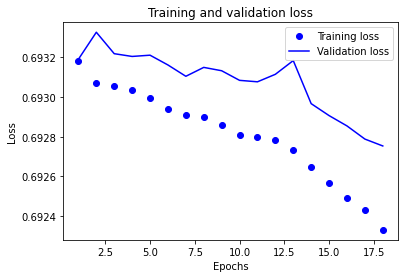

In [73]:
# 그래프 그리기

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

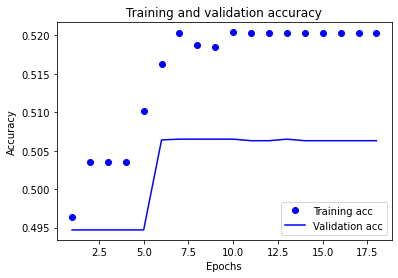

In [74]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()